<ipython-input-10-82944f21c951>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm.tqdm_notebook(f.getmembers()):


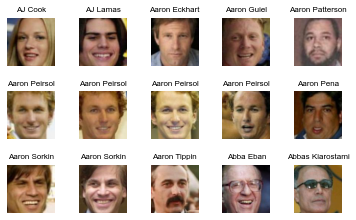

In [10]:
import numpy as np
import os
import cv2
import tarfile
import tqdm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
#
IMAGES_FILE = 'lfw_deepfunneled.tgz'
#
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype = np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
#
def load_lfw_dataset(dx = 61, dy = 61, dim_x = 48, dim_y = 48, go = True):
    all_photos = []
    photo_ids = []
    with tarfile.open(IMAGES_FILE) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            name = m.name # Имя файла, например, Art_Hoffmann_0001.jpg или Art_Hoffmann_0002.jpg
            if m.isfile() and name.endswith('.jpg'):
                # Подготовка изображения
                img = decode_image_from_raw_bytes(f.extractfile(m).read())
                if go: img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dim_x, dim_y))
                # Имя, фамилия персоны и номер фотографии
                fname = os.path.split(name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                all_photos.append(img)
                photo_ids.append([photo_number, person_id])
    return all_photos, photo_ids
#
all_photos, photo_ids = load_lfw_dataset(dim_x = 250, dim_y = 250, go = True)
title_font = {'fontname':'Arial', 'size':'8', 'color':'black'}
for i in range(15):
    plt.subplot(3, 5, i + 1)
    psn = all_photos[i]
    plt.title(photo_ids[i][1], **title_font)
    plt.imshow(psn)
    plt.axis('off')
plt.subplots_adjust(hspace = 0.05, wspace = 0.5)
plt.show()

In [ ]:
print('?')
print('http://100byte.ru/python/lfw/lfw.html')

In [22]:
print('дальше вообще непонятная дичь')

дальше вообще непонятная дичь


In [20]:
import numpy as np
import os
import cv2
import pandas as pd
import tarfile
import tqdm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import sys # Для sys.exit()
import struct # Для вывода в файл и последующей загрузки
from sklearn.model_selection import train_test_split
#
import time
import keras
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K
#
def myLoss(y_true, y_pred):
    dist = K.sqrt(K.sqrt(K.sum(K.square(y_pred - y_true))))
    err = dist
    return err # Вернет тензор с shape=(?,)
#
IMAGES_FILE = "lfw_deepfunneled.tgz"
#
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype = np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
def load_lfw_dataset(dx = 61, dy = 61, dim_x = 48, dim_y = 48, go = True):
    print('Загрузка лиц из исходных файлов')
    # Читаем фоторгафии
    all_photos = []
    photo_ids = []
    with tarfile.open(IMAGES_FILE) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            name = m.name # Имя файла, например, Art_Hoffmann_0001.jpg или Art_Hoffmann_0002.jpg
            if m.isfile() and name.endswith('.jpg'):
                # Подготовка изображения
                img = decode_image_from_raw_bytes(f.extractfile(m).read())
                if go: img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dim_x, dim_y))
                # Имя, фамилия персоны и номер фотографии
                fname = os.path.split(name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                all_photos.append(img)
                photo_ids.append([photo_number, person_id])
    all_photos2 = []
    photo_ids2 = []
    i = 0
    cnt = len(photo_ids) - 1
    ind = 0
    while i < cnt:
        nm = photo_ids[i][1]
        i += 1
        if photo_ids[i][1] == nm:
            added = True
            tmp = photo_ids[i - 1]
            tmp[0] = ind
            photo_ids2.append(tmp)
            all_photos2.append(all_photos[i - 1])
            while photo_ids[i][1] == nm and i < cnt:
                photo_ids2.append(tmp)
                all_photos2.append(all_photos[i])
                i += 1
            ind += 1
        else:
            added = False
    if added:
        photo_ids2.append(tmp)
        all_photos2.append(all_photos[i - 1])
    all_photos2 = np.stack(all_photos2).astype('uint8')
    return all_photos2, photo_ids2
def saveToFiles(fn, nPh, all_photos, photo_ids):
    fn2 = fn + '.bin'
    fn3 = fn + '_id.bin'
    fn4 = fn + '_names.txt'
    fp = open('amt.bin', 'wb')
    fp2 = open(fn2, 'wb')
    fp3 = open(fn3, 'wb')
    fp.write(struct.pack('i', nPh))
    fp2.write(all_photos)
    fp.close()
    fp2.close()
    names = []
    for i in range(nPh):
        fp3.write(struct.pack('i', photo_ids[i][0]))
        nm = photo_ids[i][1]
        if nm not in names: names.append(nm)
    fp3.close()
    fp4 = open(fn4, 'w')
    for m in names:
        fp4.write(m + '\n')
    fp4.close()
    print('Сохранены файлы amt.bin, ' + fn2 + ', ' + fn3 + ' и ' + fn4)
def saveToBin():
    print('Сохраняем данные в двоичные и текстовый файлы')
    show = False # False True
    if show:
        all_photos, photo_ids = load_lfw_dataset(dim_x = 250, dim_y = 250, go = False)
    else:
        all_photos, photo_ids = load_lfw_dataset(dim_x = w, dim_y = h, go = True)
    print(type(all_photos)) # class 'numpy.ndarray'
    print(type(photo_ids)) # class 'list'
    print(len(all_photos), len(photo_ids)) # 9164 9164
    print(all_photos.shape) # (9164, 128, 128, 3) if show else (9164, w, h, 3)
    ##print(photo_ids[:20])
    # [[0, 'Aaron Peirsol'], [0, 'Aaron Peirsol'], [0, 'Aaron Peirsol'], [0, 'Aaron Peirsol'],
    # [1, 'Aaron Sorkin'], [1, 'Aaron Sorkin'],
    # [2, 'Abdel Nasser Assidi'], [2, 'Abdel Nasser Assidi'],
    # [3, 'Abdoulaye Wade'], [3, 'Abdoulaye Wade'], [3, 'Abdoulaye Wade'], [3, 'Abdoulaye Wade'],
    # [4, 'Abdullah'], [4, 'Abdullah'], [4, 'Abdullah'], [4, 'Abdullah'],
    # [5, 'Abdullah Gul'], [5, 'Abdullah Gul'], [5, 'Abdullah Gul'], [5, 'Abdullah Gul']]
    if show:
        title_font = {'fontname':'Arial', 'size':'8', 'color':'black'}
        for i in range(15):
            plt.subplot(3, 5, i + 1)
            psn = all_photos[i]
            plt.title(photo_ids[i][1], **title_font)
            plt.imshow(psn)
            plt.axis('off')
        plt.subplots_adjust(hspace = 0.05, wspace = 0.5)
        plt.show()
    nPh = len(photo_ids)
    saveToFiles(fn, nPh, all_photos, photo_ids)
    sys.exit()
def loadDataFromBinFiles(fn, w, h):
    print('Загрузка данных из двоичных файлов')
    fn0 = 'amt.bin'
    fn2 = fn + '.bin'
    fn3 = fn + '_id.bin'
    fn4 = fn + '_names.txt'
    fp = open(fn0, 'rb')
    nPh = fp.read()
    fp.close()
    nPh = struct.unpack('i', nPh) # (9164,)
    with open(fn2, 'rb') as read_binary:
        photos = np.fromfile(read_binary, dtype = np.uint8)
    with open(fn3, 'rb') as read_binary:
        labels = np.fromfile(read_binary, dtype = np.int32)
    #with open(fn4, 'r') as f: names = f.read() # Имена персон
    #names = names.split('\n') # Строку в список
    #if names[len(names) - 1] == '': del names[-1]
    return nPh[0], photos.reshape(nPh[0], w, h, 3), labels
def showPics(show, photos, labels):
    if show:
        for i in range(40):
            plt.subplot(5, 8, i + 1)
            psn = photos[i]
            plt.title(labels[i])
            plt.imshow(psn)
            plt.axis('off')
        plt.subplots_adjust(hspace = 0.05, wspace = 0.25)
        plt.show()
        sys.exit()
def showOnePic(i, j, photos_02, ids_02, k, L, m, showTitle):
    j += 1
    plt.subplot(5, 8, j)
    psn = photos_02[i][:, :, k:L] # или photos_02[i, :, :, k:L], если photos_02 - это массив
    if showTitle:
        plt.title(str(ids_02[i][m, 0]) + '_' + str(ids_02[i][2, 0]))
    else:
        plt.title(str(ids_02[i]))
    plt.imshow(psn)
    plt.axis('off')
    return j
def showPairs(photos_02, ids_02, first, showTitle = False, nGood = 0, nBad = 0):
    j = 0
    for i in range(0, 20):
        k = i if first else np.random.choice(range(nGood, nGood + nBad))
        j = showOnePic(k, j, photos_02, ids_02, 0, 3, 0, showTitle)
        j = showOnePic(k, j, photos_02, ids_02, 3, 6, 1, showTitle)
    plt.show()
def makeSomeGoodPairs(photos, labels, nPh):
    # Создаем пары для каждой персоны, сочетая первую фотографию со второй
    # вторую с третьей и т. д.
    # Если пара фотографий принадлежит одной персоне, то photos_class[*] = 0,
    # в противном случае photos_class[*] = 1
    photos_02, ids_02, photos_class = [], [], []
    sz = photos[0].shape[0]
    i = 0
    while i < nPh - 1:
        j = i
        lb = labels[j]
        L = 0
        while i < nPh and labels[i] == lb:
            i += 1
            L += 1
        if i < nPh:
            for m in range(1, L):
                arrP = np.zeros(shape = (sz, sz, 6), dtype = np.uint8)
                arr_ids = np.zeros(shape = (3, 1), dtype = np.int32)
                arrP[:, :, 0:3] = photos[j + m - 1]
                arrP[:, :, 3:6] = photos[j + m]
                arr_ids[0, 0] = lb
                arr_ids[1, 0] = lb
                arr_ids[2, 0] = m - 1 # Номер пары текущего лица
                photos_02.append(arrP)
                ids_02.append(arr_ids)
                photos_class.append(0)
    return photos_02, ids_02, photos_class
def makeSomeBadPairs(photos, labels, nPh, nPairs, photos_02, ids_02, photos_class):
    # nPairs - число "хороших" пар в photos_02 (результат makeSomeGoodPairs)
    # Создаем nPairs пар, сочетая фотографии разных персон
    # В этом случае photos_class[*] = 1
    sz = photos[0].shape[0]
    n = 0
    for s in range(23):
        ph_temp, ids_temp = [], []
        i = 0
        while i < nPh - 1:
            j = i
            lb = labels[j]
            k = 0
            while i < nPh and labels[i] == lb:
                i += 1
                k += 1
            if i < nPh and k > s:
                ph_temp.append(photos[j + s])
                ids_temp.append(lb)
        amt = len(ph_temp) - 1
        for i in range(amt):
            arrP = np.zeros(shape = (sz, sz, 6), dtype = np.uint8)
            arr_ids = np.zeros(shape = (3, 1), dtype = np.int32)
            arrP[:, :, 0:3] = ph_temp[i]
            arrP[:, :, 3:6] = ph_temp[i + 1]
            arr_ids[0, 0] = ids_temp[i]
            arr_ids[1, 0] = ids_temp[i + 1]
            arr_ids[2, 0] = s # Номер пары текущего лица
            photos_02.append(arrP)
            ids_02.append(arr_ids)
            photos_class.append(1)
            n += 1
            if n >= nPairs: return photos_02, ids_02, photos_class
    return photos_02, ids_02, photos_class
def prepData(fn, w, h, useTest):
    # Каждая персона при загрузке данных получила номер: 0, 1, ...; эти номера содержит массив labels
    nPh, photos, labels = loadDataFromBinFiles(fn, w, h) # nPh = 9164; photos - numpy.ndarray
    ##showPics(True, photos, labels) # False True
    ##sys.exit()
    #
    # Создаем хорошие пары для каждой персоны, сочетая первую фотографию со второй, вторую с третьей и т. д.
    photos_02, ids_02, photos_class = makeSomeGoodPairs(photos, labels, nPh)
    nGood = len(photos_class) # Число хороших пар
    # Создаем плохие пары для каждой персоны
    photos_02, ids_02, photos_class = makeSomeBadPairs(photos, labels, nPh, len(photos_02), photos_02, ids_02, photos_class)
    nBad = len(photos_class) - nGood
    print('Число хороших пар:', nGood) # 7481
    print('Число плохих пар:', nBad) # 7481
    # 1: False True - показываем хорошие пары; 2: False True - выводим заголовок
    ##showPairs(photos_02, ids_02, True, True, nGood, nBad)
    ##sys.exit()
    photos_02 = np.array(photos_02)
    photos_class = np.array(photos_class)
    ##print(photos_02.shape) # (14962, w, h, 6)
    #
    if useTest:
        X_train, X_test, y_train, y_test = train_test_split(photos_02, photos_class, test_size = 0.1, random_state = 348)
        y_test_0 = y_test
        n_test = len(y_test)
        print('Размер тестовой выборки:', n_test)
    else:    
        X_train, y_train = photos_02, photos_class
        X_test = y_test = y_test_0 = n_test = 0
    #
    ##showPairs(X_train, y_train, True)
    ##showPairs(X_test, y_test, True)
    ##sys.exit()
    #
    # Преобразование из диапазона 0-255 в диапазон 0.0-1.0
    X_train = X_train.astype('float32')
    X_train = X_train / 255.0
    y_train = keras.utils.to_categorical(y_train, 2)
    if useTest:
        X_test = X_test.astype('float32')
        X_test = X_test / 255.0
        y_test = keras.utils.to_categorical(y_test, 2)
    return X_train, X_test, y_train, y_test, y_test_0, n_test
def createModel(input_shape, loss, optimizer):
    print('Функция потерь:', loss)
    visible = Input(shape = input_shape)
    conv = Conv2D(16, kernel_size = (3, 3), padding = 'same', activation = 'relu')(visible)
    pool = MaxPooling2D(pool_size = (2, 2), padding = 'same')(conv)
    conv2 = Conv2D(48, kernel_size = (3, 3), padding = 'same', activation = 'relu')(pool)
    pool2 = MaxPooling2D(pool_size = (2, 2), padding = 'same')(conv2)
    flat = Flatten()(pool2)
    # Интерпретирующая часть модели
    dense = Dense(1024, activation = 'relu')(flat)
    ##drop = Dropout(0.2)(dense)
    dense2 = Dense(64, activation = 'relu')(dense) # linear relu
    output = Dense(2, activation = 'softmax')(dense2)
    model = Model(inputs = visible, outputs = output)
    #
    model.summary()
    ##plot_model(model, to_file = 'lfw.png')
    #
    model.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy']) # binary_accuracy
    return model
# Проверка
def checkModel(model, X_test, y_test, y_test_0, predict, n_test, useTest, showErrPics):
    if not useTest: predict = False
    if predict:
        print('Прогнозирование')
        y_pred = model.predict(X_test) # , batch_size = 10
        classes = []
        for m in y_pred:
            classes.append(np.argmax(m))
        # np.sum(classes == y_test_0) вернет сумму случаев, когда classes[i] = y_test_0[i]
        nClassified = np.sum(classes == y_test_0)
        nNotClassified = n_test - nClassified
        acc = 100.0 * nClassified / n_test
        print("Число ошибочно классифицированных лиц: " + str(nNotClassified))
        print("Точность прогнозирования: " + str(acc) + '%')
        if showErrPics:
            n = 0
            j = 0
            for i in range(n_test):
                if y_test_0[i] != classes[i]:
                    n += 1
                    if (n > nNotClassified): break
                    print(str(n) + '. i = ' + str(i))
                    if j < 40:
                        j = showOnePic(i, j, X_test, y_test_0, 0, 3, 0, False)
                        j = showOnePic(i, j, X_test, y_test_0, 3, 6, 1, False)
            plt.show()        
    else:
        print('Тестирование')
        start_time = time.time()
        if useTest:
            score = model.evaluate(X_test, y_test, verbose = 0)
        else:
            score = model.evaluate(X_train, y_train, verbose = 0)
        print('Потери при тестировании: ', score[0])
        print('Точность при тестировании:', score[1])
        print('Время тестирования: ', (time.time() - start_time))
#
# Главная программа
#
pathToData = 'G:/AM/НС/lfw/'
# Имя hdf5-файла с весами модели. Используется, когда loadModel = True
fileWeights = pathToData + 'weights.11' + '.hdf5' # Файл с весами модели (loadModel)
filepath = pathToData + "weights_2.{epoch:02d}.hdf5" # Шаблон файла для сохранения весов модели
# Загрузка весов из ранее сохраненного файла
loadModel = True # False False
# Флаг обучения модели
fitModel = True # True False
useTest = True # True False
predict = False
showErrPics = True
showFig = False
epochs = 1
#
w = h = 48
input_shape = (w, h, 6)
userLoss = False # False True
if userLoss:
    loss = myLoss
else:
    loss = keras.losses.poisson
save_lfw = False # True False
optimizer = keras.optimizers.Adam()
fn = 'photos' # Начало имени бинарных файлов, в которые выгружаются фотогграфии лиц и их идентификаторы
batch_size = 256
#
np.random.seed(348)
#
if save_lfw: saveToBin()
#
# Загружаем и готови бучающие и тестовые данные
X_train, X_test, y_train, y_test, y_test_0, n_test = prepData(fn, w, h, useTest)
#
# Создаем модель нейронной сети
model = createModel(input_shape, loss, optimizer)
#
if loadModel:
    print('Загрузка весов из файла ' + fileWeights)
    model.load_weights(fileWeights)
if fitModel:
    print('Обучение')
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 0,
                                                 save_weights_only = True,
                                                 save_best_only = False, mode = 'min', period = 1)
    callbacks_list = [checkpoint]
    start_time = time.time()
    history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs,
                        verbose = 2, validation_data = (X_test, y_test), callbacks = callbacks_list)
    print('Число эпох: ', epochs)
    print('batch_size = ', batch_size)
    print('Время обучения: ', (time.time() - start_time))
    # Вывод истории в файлы
    suff = '.txt'
    f_loss = 'loss' + suff
    f_acc = 'acc' + suff
    f_val_loss = 'val_loss' + suff
    f_val_acc = 'val_acc' + suff
    print('История сохранена в файлы ' + f_loss + ', ' + f_acc + ', ' + f_val_loss + ' и ' + f_val_acc)
    with open(pathToData + f_loss, 'w') as output:
        for val in history.history['loss']: output.write(str(val) + '\n')
    with open(pathToData + f_acc, 'w') as output:
        for val in history.history['acc']: output.write(str(val) + '\n')
    with open(pathToData + f_val_loss, 'w') as output:
        for val in history.history['val_loss']: output.write(str(val) + '\n')
    with open(pathToData + f_val_acc, 'w') as output:
        for val in history.history['val_acc']: output.write(str(val) + '\n')
    if showFig and not predict:
        # Вывод графиков
        yMax = max(history.history['acc'])
        cnt = len(history.history['acc'])
        rng = np.arange(cnt)
        fig, ax = plt.subplots(figsize = (6.2, 3.8))
        ax.scatter(rng, history.history['acc'], marker = 'o', c = 'blue', edgecolor = 'black', label = 'Точность')
        ax.set_title('Точность в процессе обучения')
        ax.set_ylabel('Точность')
        ax.set_xlabel('Эпоха')
        ax.set_xlim([0.9, 1.1 * (cnt - 1)])
        ax.set_ylim([0, 1.1 * yMax])
        fig.show()
# Проверка
checkModel(model, X_test, y_test, y_test_0, predict, n_test, useTest, showErrPics)

Загрузка данных из двоичных файлов


FileNotFoundError: [Errno 2] No such file or directory: 'amt.bin'